In [ ]:
# Core Libraries
import numpy as np
import pandas as pd
import random
import os
import re
import pickle

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
!pip install wordcloud


# Model Training & Evaluation
from sklearn.model_selection import StratifiedKFold, cross_val_score,train_test_split

from sklearn.metrics import (
    accuracy_score, precision_score, 
     confusion_matrix, classification_report,precision_recall_curve,roc_curve,auc
)

from sklearn.utils.class_weight import compute_class_weight

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sohom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sohom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Sohom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Sohom\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
'unzip' is not recognized as an internal or external command,
operable program or batch file.



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
print("\n----- Dataset Overview -----")
print("Dataset shape:", df.shape)
print("First 5 rows:\n", df.head(5))


----- Dataset Overview -----
Dataset shape: (5572, 5)
First 5 rows:
      v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [5]:
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [6]:
df["No_of_Characters"] = df["message"].apply(len)
df["No_of_Words"] = df.apply(lambda row: word_tokenize(row["message"]), axis=1).apply(len)
df["No_of_sentence"] = df.apply(lambda row: sent_tokenize(row["message"]), axis=1).apply(len)

In [7]:
stop_words = set(stopwords.words("english"))
spam_words = ' '.join(df[df['label'] == 1]['message'])
ham_words = ' '.join(df[df['label'] == 0]['message'])

In [8]:
print("\n----- Data Quality Check -----")
print("Missing values:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())


----- Data Quality Check -----
Missing values:
 label               0
message             0
No_of_Characters    0
No_of_Words         0
No_of_sentence      0
dtype: int64
Duplicate rows: 403


In [9]:
df.drop_duplicates(inplace=True)
print("New dataset shape after removing duplicates:", df.shape)

New dataset shape after removing duplicates: (5169, 5)


Removing outliers

In [10]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_cleaned = remove_outliers_iqr(df, "No_of_Characters")
df_cleaned = remove_outliers_iqr(df_cleaned, "No_of_Words")

In [11]:
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
        
    # Remove non-alphabetical characters but keep numbers and spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)  
    
    # Tokenize text
    words = word_tokenize(text)

    # Get POS tags
    pos_tags = pos_tag(words)  

    # Lemmatize using POS tags
    words = [lemmatizer.lemmatize(word, pos='v' if tag.startswith('V') else 
                                 ('n' if tag.startswith('NN') else 
                                  ('a' if tag.startswith('JJ') else 
                                   ('r' if tag.startswith('RB') else 'n'))))
            for word, tag in pos_tags]

    # Rejoin words into a cleaned sentence
    return ' '.join(words)

# Apply preprocessing to clean the message
df_cleaned['clean_message'] = df_cleaned['message'].apply(preprocess_text)

In [12]:
def plot_history(history_list, model_name):
    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for history in history_list:
        plt.plot(history['val_accuracy'], label="Val")
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    for history in history_list:
        plt.plot(history['val_loss'], label="Val")
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
def plot_validation_accuracy(history_folds, model_name):
    val_accs = [max(hist['val_accuracy']) for hist in history_folds]
    plt.plot(range(1, len(val_accs) + 1), val_accs, label=model_name)
    plt.xlabel('Fold')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Validation Accuracy for {model_name}')
    plt.xticks(range(1, len(val_accs) + 1))
    plt.legend()
    plt.show()

In [33]:

# Set parameters
max_words = 5000  # Maximum number of words in the vocabulary
max_len = 100  # Maximum length of input sequences
embedding_dim = 100  # Dimension of the word embeddings
SEED = 42

# Initialize the tokenizer and fit it on the text data
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df_cleaned['clean_message'])

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df_cleaned['clean_message'])

# Pad sequences to ensure uniform input size
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
y = np.array(df_cleaned['label'])

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [24]:
def create_gru_model():
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim),
        Bidirectional(GRU(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(GRU(32)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
# Prepare StratifiedKFold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

history_gru_folds = []

best_gru_val_acc = 0
best_gru_model = None

# Iterate through folds and perform cross-validation for both LSTM and GRU
for fold, (train_index, val_index) in enumerate(kf.split(X,y), 1):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Initialize and fit GRU model
    gru_model = create_gru_model()
    print(f"Training GRU for fold {fold}")
    history_gru = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32, class_weight=class_weights_dict)
    history_gru_folds.append(history_gru.history)
    
    # Track best GRU model based on validation accuracy
    val_acc_gru = max(history_gru.history['val_accuracy'])
    if val_acc_gru > best_gru_val_acc:
        best_gru_val_acc = val_acc_gru
        best_gru_model = gru_model

Training GRU for fold 1
Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.8451 - loss: 0.5149 - val_accuracy: 0.9744 - val_loss: 0.1075
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9769 - loss: 0.1115 - val_accuracy: 0.9754 - val_loss: 0.0981
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9904 - loss: 0.0484 - val_accuracy: 0.9400 - val_loss: 0.1954
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9937 - loss: 0.0248 - val_accuracy: 0.9813 - val_loss: 0.0876
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9956 - loss: 0.0207 - val_accuracy: 0.9813 - val_loss: 0.0904
Training GRU for fold 2
Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.8556 - loss: 0.4980 - val_accuracy: 0.9685 - val_loss: 0.1453
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9740 - loss: 0.1025 - val_accuracy: 0.9803 - val_loss: 0.0679
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - 

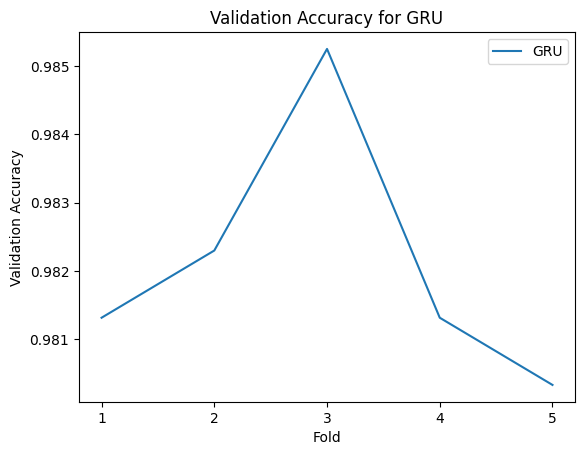

In [28]:
plot_validation_accuracy(history_gru_folds, "GRU")

In [29]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Confusion Matrix for Best GRU Model


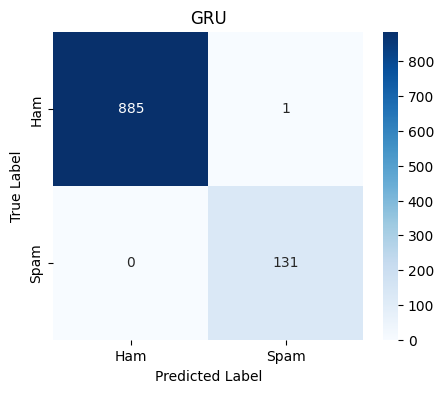

In [30]:
y_pred_gru=best_gru_model.predict(X_val)
y_pred_gru=(y_pred_gru>0.5).astype(int)

# Plot confusion matrix for best GRU model
print("Confusion Matrix for Best GRU Model")
plot_confusion_matrix( y_val,y_pred_gru, "GRU")

In [31]:
best_gru_model.save('best_gru_model.h5')
print("Model saved successfully!")

Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('best_gru_model.h5')

# Predict
predictions = model.predict(X_test)